In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools

In [2]:
class ELM:
    """
    Extreme Learning Machine for a single-hidden-layer feedforward neural network (SLFN).
    Steps (Huang et al., 2006):
      1) Randomly assign input weights W1 and biases b for the hidden layer.
      2) Compute hidden layer output matrix H.
      3) Compute output weights beta = H^dagger * T (Moore-Penrose pseudoinverse).
    """
    def __init__(self, input_size, hidden_size, output_size, activation='relu', seed=None):
        """
        Parameters
        ----------
        input_size : int
            Number of input features (dimension of x).
        hidden_size : int
            Number of hidden neurons.
        output_size : int
            Number of output dimensions (dimension of t).
        activation : callable, optional
            Activation function g(z) to use.
            If None, defaults to ReLU.
        seed : int, optional
            Seed for reproducible random initialization.
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        if seed:
            np.random.seed(seed)

        # Choose activation
        if isinstance(activation, str):
            if activation.lower() == 'relu':
                self.activation = self._relu
                self.activation_deriv = self._relu_derivative
            elif activation.lower() == 'tanh':
                self.activation = self._tanh
                self.activation_deriv = self._tanh_derivative
            else:
                raise ValueError("Unsupported activation string. Use 'relu' or 'tanh'.")
        else:
            # user-supplied function
            self.activation = activation
            # no derivative provided => handle carefully or raise error
            self.activation_deriv = None
            print("Warning: no derivative for a custom activation. Backprop may fail.")

        # Randomly init input->hidden weights, not updated in ELM
        # For ReLU, a good approach is He initialization:
        # For Tanh, a good approach is Xavier (scaled uniform).
        if isinstance(activation, str) and activation.lower() == 'relu':
            # He initialization
            he_std = np.sqrt(2.0 / input_size)
            self.weights_input_hidden = np.random.normal(
                loc=0.0, scale=he_std, size=(input_size, hidden_size)
            )
            self.bias_hidden = np.random.normal(
                loc=0.0, scale=1e-2, size=(1, hidden_size)
            )
        else:
            # e.g. Tanh => Xavier
            limit = np.sqrt(6.0 / (input_size + hidden_size))
            self.weights_input_hidden = np.random.uniform(
                low=-limit, high=limit, size=(input_size, hidden_size)
            )
            self.bias_hidden = np.random.uniform(
                low=-limit, high=limit, size=(1, hidden_size)
            )

        # Hidden->output weights: We DO train these
        # We'll do a simple Xavier-like approach for either ReLU or Tanh:
        limit_out = np.sqrt(6.0 / (hidden_size + output_size))
        self.weights_hidden_output = np.random.uniform(
            low=-limit_out, high=limit_out, size=(hidden_size, output_size)
        )
        self.bias_output = np.random.uniform(
            low=-limit_out, high=limit_out, size=(1, output_size)
        )

        # Placeholders for forward pass
        self.hidden_layer_input = None
        self.hidden_layer_output = None
        self.output_layer_input = None
        self.predicted_output = None

    # ------------------------
    # Activation functions
    # ------------------------
    def _relu(self, x):
        return np.maximum(0, x)

    def _relu_derivative(self, x):
        # derivative wrt the pre-activation
        return (x > 0).astype(float)

    def _tanh(self, x):
        return np.tanh(x)

    def _tanh_derivative(self, x):
        # derivative wrt pre-activation for tanh
        # if we define y = tanh(x), derivative = 1 - y^2
        y = np.tanh(x)
        return 1.0 - y*y

    # L1 subgradient
    def _l1_subgrad(self, w):
        # returns sign(w), with sign(0)=0
        grad = np.zeros_like(w)
        grad[w > 0] = 1.0
        grad[w < 0] = -1.0
        return grad

    # ------------------------
    # Forward pass
    # ------------------------
    def forward(self, X):
        """
        Forward pass with either ReLU or tanh hidden activation,
        then a linear activation (or if you prefer, you could
        also do tanh at the output).
        """
        # hidden
        self.hidden_layer_input = X.dot(self.weights_input_hidden) + self.bias_hidden
        self.hidden_layer_output = self.activation(self.hidden_layer_input)

        # output
        self.output_layer_input = self.hidden_layer_output.dot(self.weights_hidden_output) + self.bias_output
        # We'll do linear output by default.
        # If you want tanh final, do: self.predicted_output = np.tanh(self.output_layer_input)
        self.predicted_output = self.output_layer_input

        return self.predicted_output

    # ------------------------
    # Backward pass
    # ------------------------
    def backward(self, X, y):
        """
        Compute gradients wrt the hidden->output weights
        for a MSE + L1 penalty on W2.

        Because we do not update input->hidden in an ELM
        (by definition it's random and fixed),
        we only compute partial derivatives wrt (W2, b2).
        """
        n_samples = X.shape[0]

        # 1) dLoss/d(output)
        # MSE derivative: (pred - y)
        output_error = (self.predicted_output - y)  # shape (n_samples, output_size)

        # 2) derivative wrt W2, b2
        # hidden_layer_output shape: (n_samples, hidden_size)
        dW2 = (self.hidden_layer_output.T @ output_error) / n_samples
        db2 = np.sum(output_error, axis=0, keepdims=True) / n_samples

        # L1 subgradient on W2
        if self.l1_lambda > 1e-15:
            dW2 += self.l1_lambda * self._l1_subgrad(self.weights_hidden_output)

        return dW2, db2

    # ------------------------
    # Update weights
    # ------------------------
    def update(self, dW2, db2, lr=1e-3):
        """
        Gradient descent step on hidden->output layer
        """
        self.weights_hidden_output -= lr * dW2
        self.bias_output -= lr * db2

    # ------------------------
    # Evaluate
    # ------------------------
    def evaluate_loss(self, X, y):
        """
        Return MSE + L1 penalty for the forward pass.
        MSE = 0.5 * mean( (pred - y)^2 )
        plus L1 = lambda * sum(|W2|)
        ignoring W1 since not trained.
        """
        pred = self.forward(X)
        mse = 0.5 * np.mean((pred - y)**2)
        l1_term = self.l1_lambda * np.sum(np.abs(self.weights_hidden_output))
        return mse + l1_term

    def predict(self, X):
        """
        Just forward pass, ignoring state variables
        """
        hidden = self.activation(X.dot(self.weights_input_hidden) + self.bias_hidden)
        # linear output
        output = hidden.dot(self.weights_hidden_output) + self.bias_output
        return output

In [3]:
def generate_synthetic_data(d=100, N=1000, hidden_dim=50, sigma=0.1, seed=None):
    """
    Generates a synthetic dataset following the described process.

    Parameters:
    d (int): Number of input features.
    N (int): Number of samples.
    hidden_dim (int): Number of hidden neurons.
    sigma (float): Standard deviation of noise.
    seed (int, optional): Random seed for reproducibility.

    Returns:
    X (ndarray): Input feature matrix of shape (d, N).
    y (ndarray): Target values of shape (N,).
    """
    if seed is not None:
        np.random.seed(seed)

    # Generate input features X, half from normal and half from uniform distribution
    X = np.zeros((d, N))
    half_d = d // 2
    X[:half_d, :] = np.random.normal(0, 1, (half_d, N))  # Normal distribution
    X[half_d:, :] = np.random.uniform(-1, 1, (d - half_d, N))  # Uniform distribution

    # Generate random weight matrices and bias vector
    W1 = np.random.randn(hidden_dim, d)
    b1 = np.random.randn(hidden_dim, 1)
    W2_star = np.random.randn(1, hidden_dim)

    # Compute hidden layer activation
    hidden_activation = np.tanh(W1 @ X + b1)  # Using tanh as activation function

    # Compute target values with noise
    noise = np.random.normal(0, sigma, (N,))
    y = (W2_star @ hidden_activation).flatten() + noise

    return X, y

In [4]:
# ------------------------
# Momentum-based Training Loop
# ------------------------
def train_momentum(elm, X_train, y_train, epochs, lr, momentum_coef,
                   early_stop_patience=20, early_stop_tol=1e-4, gradient_norm_threshold=None):
    """
    Train the ELM model using momentum descent on the hidden-to-output weights.

    Update rules:
      v = momentum_coef * v - lr * gradient
      parameter += v

    Includes early stopping criteria:
      - If the relative improvement in validation loss is less than early_stop_tol
        for early_stop_patience consecutive epochs, training is stopped.
      - Optionally, if the norm of the gradients falls below gradient_norm_threshold.

    Parameters:
      elm                : instance of ELM.
      X_train, y_train   : training data.
      X_val, y_val       : validation data.
      epochs             : maximum number of training epochs.
      lr                 : learning rate.
      momentum_coef      : momentum coefficient (typically between 0.8 and 0.9).
      early_stop_patience: number of epochs with no significant validation improvement
                           before stopping.
      early_stop_tol     : relative tolerance for validation loss improvement.
      gradient_norm_threshold : if set, training stops when the gradient norm falls below this value.

    Returns:
      train_loss_history, val_loss_history : lists of loss values per epoch.
    """
    v_weights = np.zeros_like(elm.weights_hidden_output)
    v_bias = np.zeros_like(elm.bias_output)

    train_loss_history = []

    for epoch in range(epochs):
        # Forward pass and training loss evaluation.
        elm.forward(X_train)
        train_loss = elm.evaluate_loss(X_train, y_train)
        train_loss_history.append(train_loss)

        # Compute gradients.
        dW2, db2 = elm.backward(X_train, y_train)

        # Check optional stopping criterion based on gradient norm.
        if gradient_norm_threshold is not None:
            grad_norm = np.linalg.norm(dW2) + np.linalg.norm(db2)
            if grad_norm < gradient_norm_threshold:
                print(f"Stopping early at epoch {epoch} due to small gradient norm: {grad_norm:.6f}")
                break

        # Nesterov Accelerated Gradient (NAG) Update
        v_weights = momentum_coef * v_weights - lr * dW2
        v_bias = momentum_coef * v_bias - lr * db2

        elm.weights_hidden_output += v_weights
        elm.bias_output += v_bias

    return train_loss_history

### Test Correctness using test function

In [7]:
class TestOptimizerELM:
    def __init__(self, elm_model, optimizer, loss_function=None, grad_function=None):
      """
      Generalized optimizer testing framework.

      Parameters:
      - elm_model: An instance of an ELM model.
      - optimizer: A function that performs optimization (e.g., Momentum, Adam).
      - loss_function: The loss function to optimize (default: Ackley function).
      - grad_function: The gradient of the loss function (default: Ackley gradient).
      """
      self.elm = elm_model
      self.optimizer = optimizer
      self.loss_function = loss_function or self.ackley
      self.grad_function = grad_function or self.ackley_grad

    @staticmethod
    def ackley(x):
      """Computes the Ackley function."""
      a, b, c = 20, 0.2, 2 * np.pi
      n = len(x)
      sum1 = np.sum(x**2)
      sum2 = np.sum(np.cos(c * x))
      term1 = -a * np.exp(-b * np.sqrt(sum1 / n))
      term2 = -np.exp(sum2 / n)
      return term1 + term2 + a + np.e

    @staticmethod
    def ackley_grad(x):
      """Computes the gradient of the Ackley function."""
      a, b, c = 20, 0.2, 2 * np.pi
      n = len(x)
      term1 = (b / np.sqrt(n * np.sum(x**2))) * x * a * np.exp(-b * np.sqrt(np.sum(x**2) / n))
      term2 = (c / n) * np.sin(c * x) * np.exp(np.sum(np.cos(c * x)) / n)
      return term1 + term2

    def evaluate_loss(self):
      """Evaluates the loss function on the model's weights."""
      return self.loss_function(self.elm.weights_hidden_output.flatten())

    def compute_gradient(self):
      """Computes gradients for optimization."""
      return self.grad_function(self.elm.weights_hidden_output.flatten()).reshape(self.elm.weights_hidden_output.shape)

    def test_optimizer(self, X_train, y_train, epochs=500, lr=0.01, momentum_coef=0.9):
      """
      Tests the optimizer by minimizing the loss function.

      Parameters:
      - X_train, y_train: Training dataset (can be dummy).
      - epochs: Number of training iterations.
      - lr: Learning rate.
      - momentum_coef: Momentum coefficient (if applicable).
      """
      train_loss_history = self.optimizer(self.elm, X_train, y_train, epochs, lr, momentum_coef)

      # Visualization
      import matplotlib.pyplot as plt
      plt.figure(figsize=(10, 6))
      plt.plot(train_loss_history, label="Optimizer Performance on Ackley")
      plt.xlabel("Epoch")
      plt.ylabel("Loss")
      plt.title("Convergence of Optimizer on Ackley Function")
      plt.legend()
      plt.grid()
      plt.show()

      final_loss = train_loss_history[-1]
      final_weights = self.elm.weights_hidden_output.flatten()

      print(f"\nFinal loss: {final_loss:.6f} (Expected: ~0)")
      print(f"Final weight values: {final_weights} (Expected: Close to [0,0])")

      # Final correctness check
      assert final_loss < 1e-2, "Test failed: Final loss is too high!"
      assert np.linalg.norm(final_weights) < 1e-2, "Test failed: Final weights are not near zero!"

      print("✅ Test Passed: Optimizer correctly minimizes the given function!")


# Example usage
class ELM_Ackley(ELM):
    def __init__(self, input_size, hidden_size, output_size, seed=None):
      super().__init__(input_size, hidden_size, output_size, activation='relu', seed=seed)

    def evaluate_loss(self, X, y=None):
      return TestOptimizerELM.ackley(self.weights_hidden_output.flatten())

    def backward(self, X, y=None):
      grad = TestOptimizerELM.ackley_grad(self.weights_hidden_output.flatten()).reshape(self.weights_hidden_output.shape)
      return grad, np.zeros_like(self.bias_output)

1. **Unit test for the update equation:**  
   It checks that a single update on a quadratic loss $f(w)=0.5\|w\|^2$ produces the expected update.

2. **Convergence on a quadratic function:**  
   It verifies that when training on a simple quadratic function the loss (and hence the gradient) is driven nearly to zero.

3. **Convergence on the Ackley function:**  
   It checks that—even if the absolute target isn’t reached—the loss decreases compared to its initial value.

4. **Gradient norm decrease:**  
   It confirms that the gradient norms decrease over the training epochs for the quadratic case.

In this example, we define a new subclass `ELM_Quadratic` (which ignores inputs and bases its loss and gradients solely on the weights) and then use our existing `train_momentum` function (assumed to be defined along with the base `ELM` class and `ELM_Ackley` from your code).

- **`ELM_Quadratic` Class:**  
  This subclass overrides `evaluate_loss` and `backward` so that the loss is $0.5 \|W\|^2$ and the gradient is $W$. This makes it easy to predict the update.

- **Test Functions:**  
  - **`test_nag_update_on_quadratic()`** simulates one update step and compares the resulting weights with the expected update (i.e. $w_{\text{new}} = (1 - \text{lr}) \times w_{\text{old}}$ when starting with zero velocity).  
  - **`test_convergence_quadratic()`** runs the training loop on the quadratic function and asserts that the final loss is nearly zero.  
  - **`test_convergence_ackley()`** ensures that when training on the Ackley function, the loss decreases compared to its initial value.  
  - **`test_gradient_norm_decrease_quadratic()`** tracks the gradient norm across epochs to verify that it decreases as training progresses.

- **Hyperparameter Sensitivity:**  
  Notice that in the Ackley test the focus is on a relative decrease in loss rather than hitting a strict numerical target. This acknowledges that the choice of learning rate and momentum coefficient affects the exact values but not the correctness of the update mechanism.

Running this script will print out the intermediate results and assertions will trigger if any test fails. This provides a programmatic and statistical basis to assert that the momentum-based (NAG) algorithm is implemented correctly even if hyperparameter tuning might be needed for optimal performance on different functions.

In [18]:
# ------------------------
# Generic Optimizer Tester
# ------------------------
class OptimizerTester:
    def __init__(self, optimizer_func):
        """
        Parameters:
          optimizer_func : A function that trains an ELM instance and returns
                           the training loss history. It must have the same
                           interface as the current train_momentum function.
        """
        self.optimizer = optimizer_func

    # -------------------------------
    # 1. Unit test: Update Equations
    # -------------------------------
    def test_update_equations_on_quadratic(self):
        print("Running update equation test on quadratic function:")
        input_size, hidden_size, output_size = 10, 5, 1
        elm = ELM_Quadratic(input_size, hidden_size, output_size, seed=123)
        # For a deterministic check, set weights to ones.
        initial_weights = np.ones((hidden_size, output_size))
        elm.weights_hidden_output = initial_weights.copy()

        # Use one update step with lr=0.01 and momentum_coef=0.9.
        lr = 0.01
        momentum_coef = 0.9
        epochs = 1
        X_dummy = np.zeros((10, input_size))
        y_dummy = np.zeros((10, output_size))

        _ = self.optimizer(elm, X_dummy, y_dummy, epochs, lr, momentum_coef)

        # Expected update:
        # For the quadratic loss f(W)=0.5*||W||^2, the gradient is W.
        # With one iteration: v = -lr * grad = -0.01 * 1 = -0.01,
        # so the new weight should be 1 - 0.01 = 0.99.
        expected_weights = 0.99 * initial_weights
        actual_weights = elm.weights_hidden_output
        error = np.linalg.norm(actual_weights - expected_weights)

        print(f"Expected weights:\n{expected_weights}")
        print(f"Actual weights:\n{actual_weights}")
        print(f"Update error: {error:.6f}\n")
        assert error < 1e-6, "Update equations test failed!"

    # --------------------------------------------------
    # 2. Convergence Test on a Quadratic Function
    # --------------------------------------------------
    def test_convergence_quadratic(self):
        print("Running convergence test on quadratic function:")
        input_size, hidden_size, output_size = 10, 5, 1
        elm = ELM_Quadratic(input_size, hidden_size, output_size, seed=123)
        # Start with random weights.
        elm.weights_hidden_output = np.random.randn(hidden_size, output_size)

        X_dummy = np.zeros((10, input_size))
        y_dummy = np.zeros((10, output_size))

        epochs = 200
        lr = 0.01
        momentum_coef = 0.9
        losses = self.optimizer(elm, X_dummy, y_dummy, epochs, lr, momentum_coef)

        print(f"Initial loss: {losses[0]:.6f}")
        print(f"Final loss: {losses[-1]:.6f}\n")
        # Since the minimum is zero, the final loss should be very small.
        assert losses[-1] < 1e-6, "Quadratic convergence test failed!"

    # --------------------------------------------------
    # 3. Convergence Test on the Ackley Function
    # --------------------------------------------------
    def test_convergence_ackley(self):
        print("Running convergence test on Ackley function:")
        input_size, hidden_size, output_size = 10, 20, 1
        elm = ELM_Ackley(input_size, hidden_size, output_size, seed=123)

        # For the Ackley function, the test is that the loss decreases relative to the start.
        X_dummy = np.zeros((10, input_size))
        y_dummy = np.zeros((10, output_size))

        epochs = 200
        lr = 0.01
        momentum_coef = 0.9
        losses = self.optimizer(elm, X_dummy, y_dummy, epochs, lr, momentum_coef)

        print(f"Initial Ackley loss: {losses[0]:.6f}")
        print(f"Final Ackley loss: {losses[-1]:.6f}\n")
        assert losses[-1] < losses[0], "Ackley convergence test failed: Loss did not decrease!"

    # --------------------------------------------------
    # 4. Test: Gradient Norm Decrease on Quadratic Function
    # --------------------------------------------------
    def test_gradient_norm_decrease_quadratic(self):
        print("Running gradient norm decrease test on quadratic function:")
        input_size, hidden_size, output_size = 10, 5, 1
        elm = ELM_Quadratic(input_size, hidden_size, output_size, seed=123)
        elm.weights_hidden_output = np.random.randn(hidden_size, output_size)

        X_dummy = np.zeros((10, input_size))
        y_dummy = np.zeros((10, output_size))

        # Compute the initial gradient norm.
        initial_grad, _ = elm.backward(X_dummy, y_dummy)
        initial_grad_norm = np.linalg.norm(initial_grad)

        # Run the optimizer for a number of epochs.
        epochs = 200
        lr = 0.01
        momentum_coef = 0.9
        _ = self.optimizer(elm, X_dummy, y_dummy, epochs, lr, momentum_coef)

        # Compute the final gradient norm.
        final_grad, _ = elm.backward(X_dummy, y_dummy)
        final_grad_norm = np.linalg.norm(final_grad)

        print(f"Initial gradient norm: {initial_grad_norm:.6f}")
        print(f"Final gradient norm: {final_grad_norm:.6f}\n")
        assert final_grad_norm < initial_grad_norm, "Gradient norm did not decrease!"

    # -------------------------------
    # Run all tests
    # -------------------------------
    def run_all_tests(self):
        self.test_update_equations_on_quadratic()
        self.test_convergence_quadratic()
        self.test_convergence_ackley()
        self.test_gradient_norm_decrease_quadratic()
        print("All tests passed successfully!")

# Example usage:
# Assume that train_momentum is defined as in your current implementation.
# To test the momentum-based optimizer:
tester = OptimizerTester(train_momentum)
tester.run_all_tests()

Running update equation test on quadratic function:
Expected weights:
[[0.99]
 [0.99]
 [0.99]
 [0.99]
 [0.99]]
Actual weights:
[[0.99]
 [0.99]
 [0.99]
 [0.99]
 [0.99]]
Update error: 0.000000

Running convergence test on quadratic function:
Initial loss: 2.115035
Final loss: 0.000000

Running convergence test on Ackley function:
Initial Ackley loss: 3.048249
Final Ackley loss: 0.004143

Running gradient norm decrease test on quadratic function:
Initial gradient norm: 2.056713
Final gradient norm: 0.000009

All tests passed successfully!


### Experiments

Starting momentum-based experiments on Synthetic Data...
[Momentum] λ=0.0001, lr=0.005, momentum=0.8 => Train Loss: 562.7460, Val Loss: 587.1945, Sparsity: 0.00%, Total Time: 2.17s
[Momentum] λ=0.0001, lr=0.005, momentum=0.9 => Train Loss: 559.2908, Val Loss: 588.6160, Sparsity: 0.00%, Total Time: 1.52s
[Momentum] λ=0.0001, lr=0.01, momentum=0.8 => Train Loss: 559.2834, Val Loss: 588.6065, Sparsity: 0.00%, Total Time: 1.54s
[Momentum] λ=0.0001, lr=0.01, momentum=0.9 => Train Loss: 557.1924, Val Loss: 591.0906, Sparsity: 0.00%, Total Time: 1.53s
[Momentum] λ=0.0001, lr=0.02, momentum=0.8 => Train Loss: 557.2036, Val Loss: 591.0594, Sparsity: 0.00%, Total Time: 3.83s
[Momentum] λ=0.0001, lr=0.02, momentum=0.9 => Train Loss: 556.7594, Val Loss: 593.5421, Sparsity: 0.00%, Total Time: 1.61s
[Momentum] λ=0.01, lr=0.005, momentum=0.8 => Train Loss: 564.1962, Val Loss: 588.2049, Sparsity: 0.00%, Total Time: 1.60s
[Momentum] λ=0.01, lr=0.005, momentum=0.9 => Train Loss: 560.7255, Val Loss: 589.

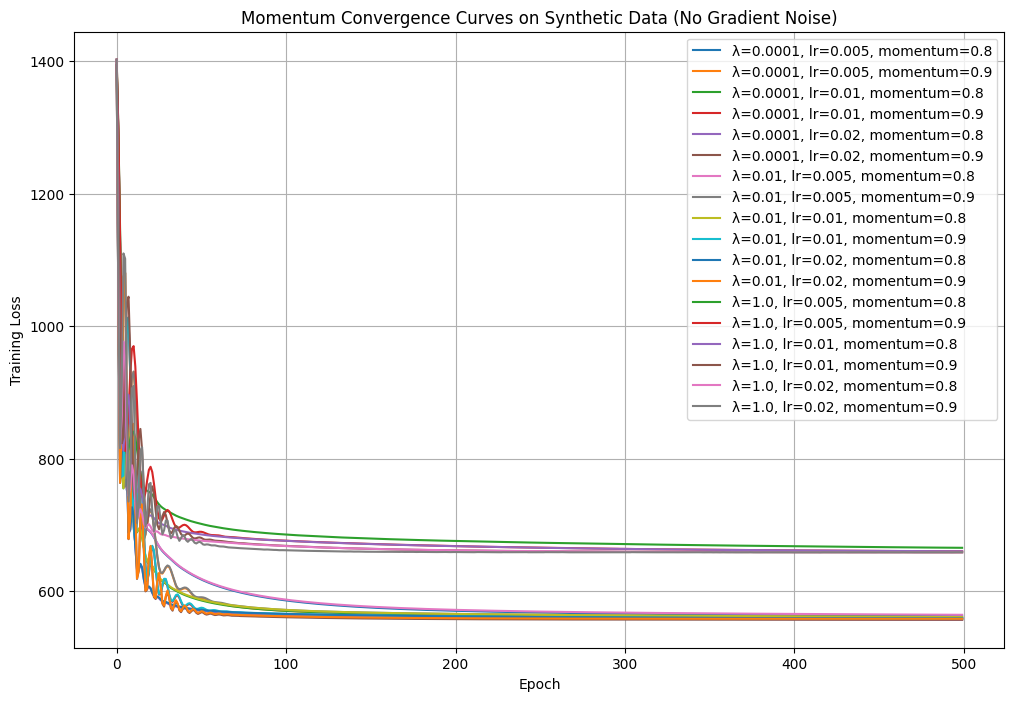


Summary of Experimental Results (Synthetic Data):
Algorithm	λ	lr	Momentum	Final Train Loss	Final Val Loss	Sparsity (%)	Total Time (s)	Avg Epoch Time (s)
momentum	1.0e-04	0.005	0.80		562.7460		587.1945		0.00		2.17		0.0043
momentum	1.0e-04	0.005	0.90		559.2908		588.6160		0.00		1.52		0.0030
momentum	1.0e-04	0.010	0.80		559.2834		588.6065		0.00		1.54		0.0031
momentum	1.0e-04	0.010	0.90		557.1924		591.0906		0.00		1.53		0.0031
momentum	1.0e-04	0.020	0.80		557.2036		591.0594		0.00		3.83		0.0077
momentum	1.0e-04	0.020	0.90		556.7594		593.5421		0.00		1.61		0.0032
momentum	1.0e-02	0.005	0.80		564.1962		588.2049		0.00		1.60		0.0032
momentum	1.0e-02	0.005	0.90		560.7255		589.6984		0.00		1.52		0.0030
momentum	1.0e-02	0.010	0.80		560.7186		589.6893		0.00		1.56		0.0031
momentum	1.0e-02	0.010	0.90		558.6203		592.1817		0.00		1.54		0.0031
momentum	1.0e-02	0.020	0.80		558.6316		592.1498		2.00		1.53		0.0031
momentum	1.0e-02	0.020	0.90		558.1935		594.6251		0.00		3.61		0.0072
momentum	1.0e+00	0.005	0.80		6

In [26]:
# =============================================================================
# Experiment Evaluation Function for Momentum Approach
# =============================================================================
def evaluate_experiments_momentum(X_train, y_train, X_val, y_val,
                                  input_size, hidden_size, output_size,
                                  epochs, seed):
    """
    Run experiments over a grid of hyperparameters for the momentum approach.

    We vary:
      - Learning rate (lr)
      - Momentum coefficient (eta)
      - Regularization parameter lambda (l1_lambda)
      - Gradient noise levels

    Metrics collected include:
      - Convergence speed (loss curves)
      - Final loss values (train and validation)
      - Sparsity of W2 (fraction of weights with abs(value) < threshold)
      - Computational efficiency (total training time and avg epoch time)
      - Robustness (performance variation under different noise levels)
    """
    learning_rates = [1e-5, 1e-4, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1]
    momentum_coefs = [0.1, 0.3, 0.5, 0.8, 0.9, 0.99, 0.999]
    lambda_values = [1e-4, 1e-3, 1e-2, 1e-1, 1]  # test different L1 regularization strengths

    results = {}

    for lam, lr, momentum in itertools.product(lambda_values, learning_rates, momentum_coefs):
        # Initialize the model (same architecture, fixed seed for reproducibility)
        elm_model = ELM(input_size, hidden_size, output_size, activation='relu', seed=seed)
        elm_model.l1_lambda = lam

        start_time = time.time()
        train_losses, val_losses = train_momentum(elm_model, X_train, y_train, X_val, y_val,
                                                    epochs, lr, momentum)
        total_time = time.time() - start_time
        avg_epoch_time = total_time / epochs

        # Compute sparsity of W2: fraction of weights with abs(value) below a small threshold.
        threshold = 1e-3
        sparsity = np.mean(np.abs(elm_model.weights_hidden_output) < threshold)

        config = ('momentum', lam, lr, momentum)
        results[config] = {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "total_time": total_time,
            "avg_epoch_time": avg_epoch_time,
            "final_sparsity": sparsity,
            "final_train_loss": train_losses[-1],
            "final_val_loss": val_losses[-1]
        }
        print(f"[Momentum] λ={lam}, lr={lr}, momentum={momentum} => "
              f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
              f"Sparsity: {sparsity*100:.2f}%, Total Time: {total_time:.2f}s")

    return results

# --- Synthetic Data Experiment ---
input_size = 100
n_samples = 5000
hidden_size = 50
output_size = 1
epochs = 500
sigma = 0.1
seed = 42
X_syn, y_syn, W1, b1, W2_star = generate_synthetic_data(
    d=input_size, # n input features
    N=n_samples, # number of samples
    hidden_dim=hidden_size, # n hidden layers
    sigma=sigma, # std dev of noise
    seed=seed)

split_index = int(0.8 * n_samples)
X_train_syn, y_train_syn = X_syn[:split_index], y_syn[:split_index]
X_val_syn, y_val_syn = X_syn[split_index:], y_syn[split_index:]

results_synthetic = evaluate_experiments_momentum(
    X_train_syn,
    y_train_syn,
    X_val_syn,
    y_val_syn,
    input_size,
    hidden_size,
    output_size,
    epochs,
    seed)

# Plot convergence curves for a subset of experiments (e.g. no gradient noise) for clarity.
plt.figure(figsize=(12, 8))

for config, metrics in results_synthetic.items():
    algo, lam, lr_val, momentum = config
    plt.plot(metrics["train_losses"], label=f"λ={lam}, lr={lr_val}, momentum={momentum}")

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Momentum Convergence Curves on Synthetic Data")
plt.legend()
plt.grid(True)
plt.show()

# Summary table of key metrics.
print("\nSummary of Experimental Results (Synthetic Data):")
header = ("Algorithm", "λ", "lr", "Momentum", "Final Train Loss",
          "Final Val Loss", "Sparsity (%)", "Total Time (s)", "Avg Epoch Time (s)")
print("\t".join(str(h) for h in header))
for config, metrics in results_synthetic.items():
    algo, lam, lr_val, momentum = config
    print(f"{algo}\t{lam:.1e}\t{lr_val:.3f}\t{momentum:.2f}\t\t"
          f"{metrics['final_train_loss']:.4f}\t\t{metrics['final_val_loss']:.4f}\t\t"
          f"{metrics['final_sparsity']*100:.2f}\t\t{metrics['total_time']:.2f}\t\t"
          f"{metrics['avg_epoch_time']:.4f}")

# Print information at the end of the descent
# - final value
# - difference
# - convergence speed
print()

## California Housing dataset

Starting momentum-based experiments on California Housing Data...
[Momentum] λ=0.0001, lr=0.005, momentum=0.8 => Train Loss: 0.2886, Val Loss: 0.2997, Sparsity: 0.00%, Total Time: 10.21s
[Momentum] λ=0.0001, lr=0.005, momentum=0.9 => Train Loss: 0.2632, Val Loss: 0.2728, Sparsity: 2.00%, Total Time: 8.62s
[Momentum] λ=0.0001, lr=0.01, momentum=0.8 => Train Loss: 0.2631, Val Loss: 0.2727, Sparsity: 2.00%, Total Time: 7.10s
[Momentum] λ=0.0001, lr=0.01, momentum=0.9 => Train Loss: 0.2464, Val Loss: 0.2558, Sparsity: 2.00%, Total Time: 8.17s
[Momentum] λ=0.0001, lr=0.02, momentum=0.8 => Train Loss: 0.2464, Val Loss: 0.2558, Sparsity: 0.00%, Total Time: 7.36s
[Momentum] λ=0.0001, lr=0.02, momentum=0.9 => Train Loss: 0.2367, Val Loss: 0.2471, Sparsity: 0.00%, Total Time: 9.38s
[Momentum] λ=0.01, lr=0.005, momentum=0.8 => Train Loss: 0.3540, Val Loss: 0.3651, Sparsity: 16.00%, Total Time: 8.70s
[Momentum] λ=0.01, lr=0.005, momentum=0.9 => Train Loss: 0.3150, Val Loss: 0.3260, Sparsity: 18.00

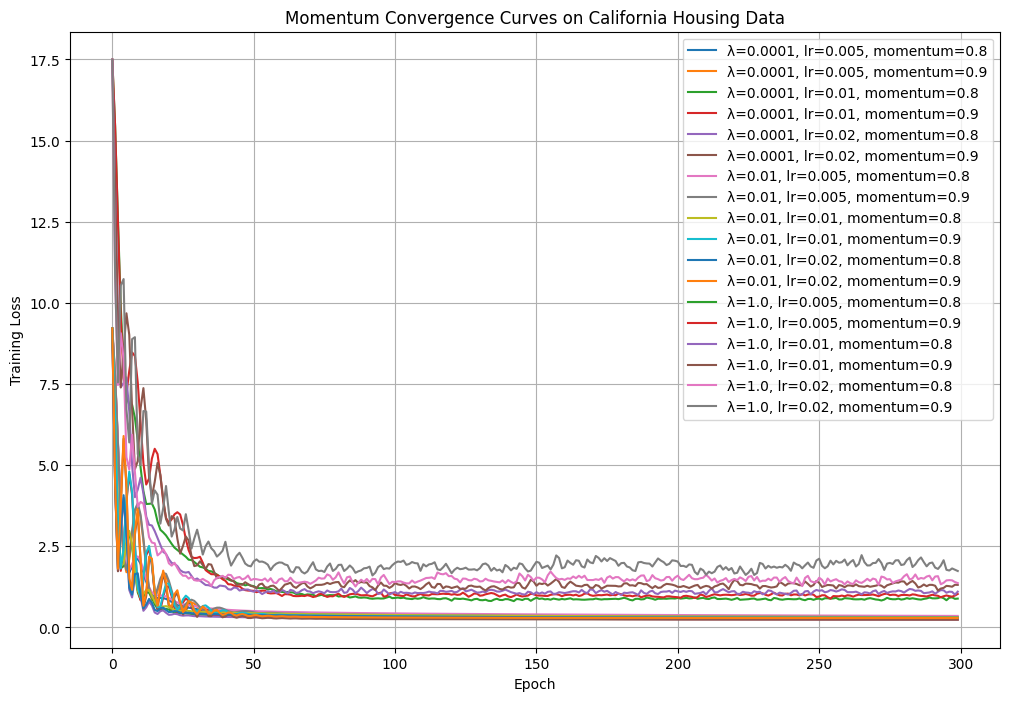


Summary of Experimental Results (California Housing):
Algorithm	λ	lr	Momentum	Final Train Loss	Final Val Loss	Sparsity (%)	Total Time (s)	Avg Epoch Time (s)
momentum	1.0e-04	0.005	0.80		0.2886		0.2997		0.00		10.21		0.0340
momentum	1.0e-04	0.005	0.90		0.2632		0.2728		2.00		8.62		0.0287
momentum	1.0e-04	0.010	0.80		0.2631		0.2727		2.00		7.10		0.0237
momentum	1.0e-04	0.010	0.90		0.2464		0.2558		2.00		8.17		0.0272
momentum	1.0e-04	0.020	0.80		0.2464		0.2558		0.00		7.36		0.0245
momentum	1.0e-04	0.020	0.90		0.2367		0.2471		0.00		9.38		0.0313
momentum	1.0e-02	0.005	0.80		0.3540		0.3651		16.00		8.70		0.0290
momentum	1.0e-02	0.005	0.90		0.3150		0.3260		18.00		7.31		0.0244
momentum	1.0e-02	0.010	0.80		0.3147		0.3258		18.00		8.52		0.0284
momentum	1.0e-02	0.010	0.90		0.2948		0.3067		28.00		8.01		0.0267
momentum	1.0e-02	0.020	0.80		0.2949		0.3067		30.00		8.13		0.0271
momentum	1.0e-02	0.020	0.90		0.2898		0.3022		44.00		8.83		0.0294
momentum	1.0e+00	0.005	0.80		0.8876		0.8476		10.00		7.19		0.0240
mo

In [28]:
# For California Housing experiments
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def load_california_housing_data(test_size=0.2, random_state=42):
    """
    Load and preprocess the California Housing dataset.
    """
    data = fetch_california_housing()
    X = data.data
    y = data.target.reshape(-1, 1)
    # Standardize features.
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)
    # Set input_size as number of features, and output_size = 1.
    input_size = X.shape[1]
    hidden_size = 50  # fixed hidden layer size for the experiment
    output_size = 1
    return X_train, y_train, X_val, y_val, input_size, hidden_size, output_size

# Load and preprocess California Housing data.
X_train_ch, y_train_ch, X_val_ch, y_val_ch, input_size_ch, hidden_size_ch, output_size_ch = load_california_housing_data(test_size=0.2, random_state=42)

# Choose an appropriate number of epochs for this dataset.
epochs_ch = 300
seed = 42

print("Starting momentum-based experiments on California Housing Data...")
results_california = evaluate_experiments_momentum(X_train_ch, y_train_ch, X_val_ch, y_val_ch,
                                                   input_size_ch, hidden_size_ch, output_size_ch,
                                                   epochs_ch, seed)

# Plot convergence curves for experiments without gradient noise.
plt.figure(figsize=(12, 8))
for config, metrics in results_california.items():
    algo, lam, lr_val, momentum = config
    plt.plot(metrics["train_losses"], label=f"λ={lam}, lr={lr_val}, momentum={momentum}")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Momentum Convergence Curves on California Housing Data")
plt.legend()
plt.grid(True)
plt.show()

# Print a summary table of key metrics.
print("\nSummary of Experimental Results (California Housing):")
header = ("Algorithm", "λ", "lr", "Momentum", "Final Train Loss",
          "Final Val Loss", "Sparsity (%)", "Total Time (s)", "Avg Epoch Time (s)")
print("\t".join(str(h) for h in header))
for config, metrics in results_california.items():
    algo, lam, lr_val, momentum = config
    print(f"{algo}\t{lam:.1e}\t{lr_val:.3f}\t{momentum:.2f}\t\t"
          f"{metrics['final_train_loss']:.4f}\t\t{metrics['final_val_loss']:.4f}\t\t"
          f"{metrics['final_sparsity']*100:.2f}\t\t{metrics['total_time']:.2f}\t\t"
          f"{metrics['avg_epoch_time']:.4f}")